### Enhanced Preprocessing with Date Alignment and Filtering

This script performs advanced preprocessing on `unlabeled_data.csv` by selecting key features (**Earnings_Surprise**, **Firm_Size**, and **method_2**) and targets (**CAR_3_Days**, **CAR_10_Days**, **CAR_30_Days**), while preserving the **Earnings_Call_Date** column for contextual reference. It handles missing values by dropping rows with excessive missingness and imputing the rest with column means. Features are standardized using **z-score normalization**, and outliers are filtered using both **IQR** and **Z-score** methods. The cleaned dataset is then realigned with the original data to retain consistency, ensuring only valid, filtered records remain for further analysis or modeling.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

# Read data
df = pd.read_csv("unlabeled_data.csv")  

df_original = df.copy()

# Store the Earnings_Call_Date column separately
if "Earnings_Call_Date" in df.columns:
    earnings_call_date = df["Earnings_Call_Date"]
    df = df.drop(columns=["Earnings_Call_Date"])  
else:
    earnings_call_date = None  

# Select only the relevant columns for preprocessing
feature_cols = ["Earnings_Surprise", "Firm_Size", "method_2"]
target_cols = ["CAR_3_Days", "CAR_10_Days", "CAR_30_Days"]
df = df[feature_cols + target_cols]  # Keep only selected columns

# Handling Missing Values 
missing_threshold = 0.2  # Maximum allowed missing ratio per row
df = df.dropna(thresh=int(len(df.columns) * missing_threshold))  # Drop rows with excessive missing values
df = df.fillna(df.mean())  # Fill remaining missing values with mean

# Standardization 
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# Outlier handling using the IQR method
Q1 = df[feature_cols].quantile(0.25)
Q3 = df[feature_cols].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df = df[~((df[feature_cols] < lower_bound) | (df[feature_cols] > upper_bound)).any(axis=1)]

# Using the Z-score method for further outlier detection
z_scores = np.abs(zscore(df[feature_cols]))
df = df[(z_scores < 3).all(axis=1)]  # Remove rows where any feature has a Z-score > 3

# Reattach the Earnings_Call_Date column
if earnings_call_date is not None:
    df["Earnings_Call_Date"] = earnings_call_date.loc[df.index] 

# Keep only the relevant columns
df = df[["Earnings_Call_Date"] + feature_cols + target_cols] 

print(df.head())

# Remove instances in original_df that are NOT in df
df_original = df_original[df_original[target_cols].apply(tuple, axis=1).isin(df[target_cols].apply(tuple, axis=1))]

  Earnings_Call_Date  Earnings_Surprise  Firm_Size  method_2  CAR_3_Days  \
0         2020-01-08          -0.015987  -0.209560  1.766959   -0.014271   
1         2020-01-08          -0.024250  -0.337852  0.066807   -0.008348   
2         2020-01-22          -0.009723  -0.338919  0.277987    0.094707   
4         2020-01-23          -0.028394  -0.322855 -1.029768    0.017126   
5         2020-01-24          -0.025039  -0.126744  0.149294   -0.021278   

   CAR_10_Days  CAR_30_Days  
0     0.010221     0.083406  
1    -0.026677    -0.059266  
2     0.089449     0.049796  
4     0.026210    -0.054972  
5     0.016655    -0.013365  


### Optimal Cluster Selection for GMM Clustering

This script applies **Gaussian Mixture Models (GMM)** to identify the optimal number of clusters (K) for the preprocessed dataset using three evaluation metrics: **BIC**, **AIC**, and **Silhouette Score**. It tests K values from 2 to 10, plots BIC and AIC curves to visualize the elbow point, and also computes silhouette scores to measure cluster quality. These visualizations guide manual selection of the most appropriate number of clusters for downstream analysis or strategy development.


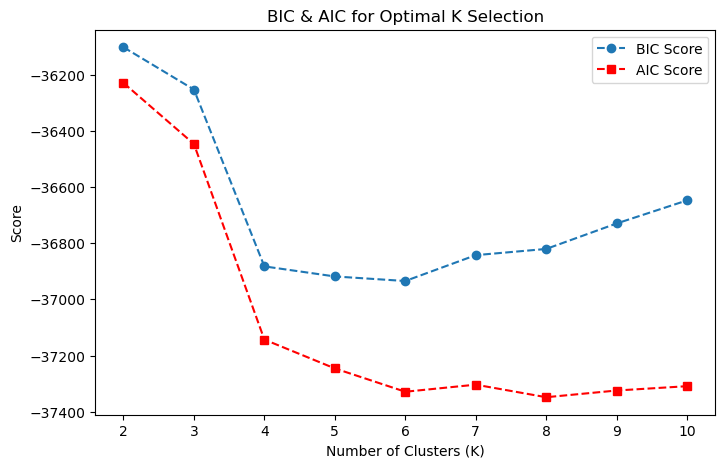

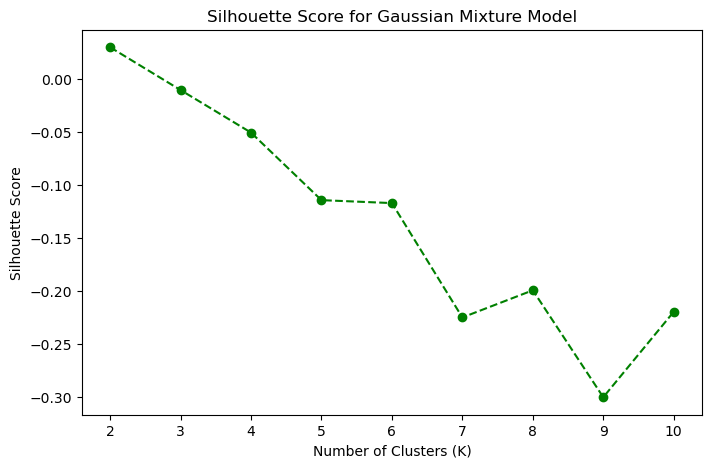

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

X = df[feature_cols]

#Using the Elbow Method with Gaussian Mixture Model (BIC and AIC for Optimal K) 
bic_scores = []  
aic_scores = []  
K_range = range(2, 11)  

for k in K_range:
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
    gmm.fit(X)
    bic_scores.append(gmm.bic(X)) 
    aic_scores.append(gmm.aic(X)) 

# Plot BIC and AIC Scores to Find Optimal K
plt.figure(figsize=(8, 5))
plt.plot(K_range, bic_scores, marker="o", linestyle="--", label="BIC Score")
plt.plot(K_range, aic_scores, marker="s", linestyle="--", label="AIC Score", color="r")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Score")
plt.title("BIC & AIC for Optimal K Selection")
plt.legend()
plt.show()

# Calculating Silhouette Score for Gaussian Mixture Model
silhouette_scores = []

for k in K_range:
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
    labels = gmm.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, labels))

# Plot the Silhouette Score graph
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker="o", linestyle="--", color="g")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Gaussian Mixture Model")
plt.show()


### GMM Clustering and CAR Interpretation (K = 6)

This script applies **Gaussian Mixture Models (GMM)** to cluster the preprocessed dataset using **Earnings_Surprise**, **Firm_Size**, and **method_2** as input features. It sets **K = 6** clusters, computes the **silhouette scores** to evaluate cluster compactness, and visualizes the results via scatter plots.

To evaluate how well the clusters capture **post-earnings stock behavior**, the script calculates and plots the **mean Cumulative Abnormal Returns (CAR)** over 3, 10, and 30 days for each cluster. Based on the CAR performance, each cluster can be labeled as Bullish, Neutral, or Bearish, enabling interpretable segmentation and facilitating strategy development based on cluster behavior.

Silhouette Score for K=6: -0.1174


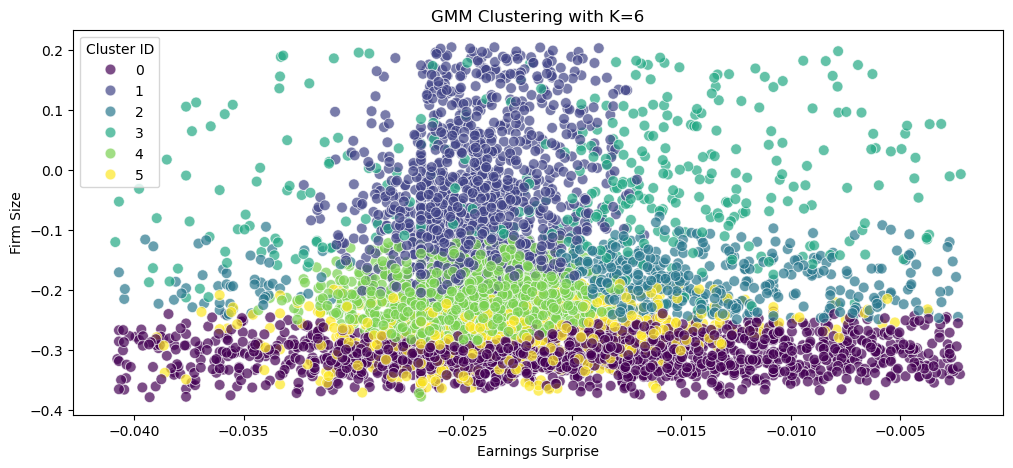

<Figure size 1200x400 with 0 Axes>

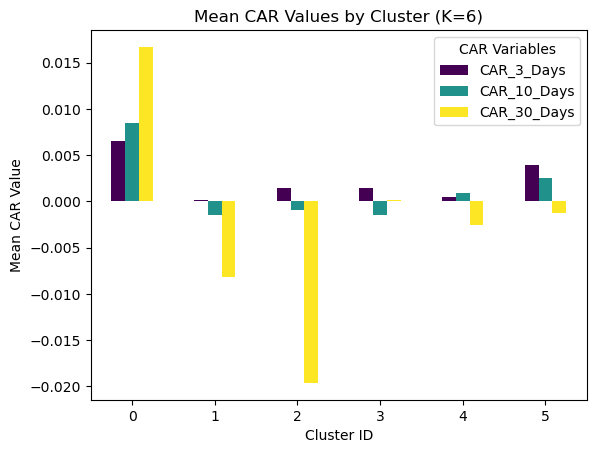

Mean CAR values for K=6:
           CAR_3_Days  CAR_10_Days  CAR_30_Days
Cluster_6                                      
0            0.006485     0.008489     0.016697
1            0.000159    -0.001513    -0.008132
2            0.001453    -0.000968    -0.019638
3            0.001390    -0.001522     0.000181
4            0.000480     0.000939    -0.002565
5            0.003960     0.002514    -0.001277
--------------------------------------------------
  Earnings_Call_Date  Earnings_Surprise  Firm_Size  method_2  CAR_3_Days  \
0         2020-01-08          -0.015987  -0.209560  1.766959   -0.014271   
1         2020-01-08          -0.024250  -0.337852  0.066807   -0.008348   
2         2020-01-22          -0.009723  -0.338919  0.277987    0.094707   
4         2020-01-23          -0.028394  -0.322855 -1.029768    0.017126   
5         2020-01-24          -0.025039  -0.126744  0.149294   -0.021278   

   CAR_10_Days  CAR_30_Days  Cluster_6  
0     0.010221     0.083406          5  
1

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Select feature columns for clustering
feature_cols = ["Earnings_Surprise", "Firm_Size", "method_2"]
X = df[feature_cols]

# Define target variables for interpretability check
target_cols = ["CAR_3_Days", "CAR_10_Days", "CAR_30_Days"]

# Clustering with K=4
k = 6
gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
df[f"Cluster_{k}"] = gmm.fit_predict(X)

# Compute silhouette score
silhouette = silhouette_score(X, df[f"Cluster_{k}"])
print(f"Silhouette Score for K={k}: {silhouette:.4f}")

# Scatter plot to visualize clustering
plt.figure(figsize=(12, 5))
sns.scatterplot(
    x=df["Earnings_Surprise"],
    y=df["Firm_Size"],
    hue=df[f"Cluster_{k}"],
    palette="viridis",
    s=60,
    alpha=0.7
)
plt.xlabel("Earnings Surprise")
plt.ylabel("Firm Size")
plt.title(f"GMM Clustering with K={k}")
plt.legend(title="Cluster ID")
plt.show()

# Bar plot: Mean CAR values for each cluster
cluster_means = df.groupby(f"Cluster_{k}")[target_cols].mean()

plt.figure(figsize=(12, 4))
cluster_means.plot(kind="bar", colormap="viridis")
plt.xlabel("Cluster ID")
plt.ylabel("Mean CAR Value")
plt.title(f"Mean CAR Values by Cluster (K={k})")
plt.legend(title="CAR Variables")
plt.xticks(rotation=0)
plt.show()

# Print the mean values of CAR variables for each cluster
print(f"Mean CAR values for K={k}:")
print(cluster_means)
print("-" * 50)

print(df.head())


### Label Assignment and Dataset Splitting

Each cluster from the K=6 GMM model is mapped to a category: **Bullish**, **Bearish**, or **Neutral** based on post-earnings CAR behavior. The mapping is defined manually to reflect the financial interpretation of each cluster's average performance.

For model development, the data is split into **training** and **test sets** based on year, with data from **2024** reserved for testing. The final labeled datasets are saved as `training_data.csv` and `test_data.csv`.


In [12]:
mapping = {0: "Bullish", 1: "Bearish", 2: "Bearish", 3: "Neutral", 4: "Neutral", 5: "Neutral"}
df["Category"] = df["Cluster_6"].map(mapping)

df = df.drop(columns=["Cluster_6"])

df.head()

,Earnings_Call_Date,Earnings_Surprise,Firm_Size,method_2,CAR_3_Days,CAR_10_Days,CAR_30_Days,Category
0,2020-01-08,-0.015987,-0.209560,1.766959,-0.014271,0.010221,0.083406,Neutral
1,2020-01-08,-0.024250,-0.337852,0.066807,-0.008348,-0.026677,-0.059266,Bullish
2,2020-01-22,-0.009723,-0.338919,0.277987,0.094707,0.089449,0.049796,Bullish
4,2020-01-23,-0.028394,-0.322855,-1.029768,0.017126,0.026210,-0.054972,Bullish
5,2020-01-24,-0.025039,-0.126744,0.149294,-0.021278,0.016655,-0.013365,Bearish


In [ ]:
# Set index and ensure it's sorted before using .update()
df.set_index(target_cols, inplace=True)
df.sort_index(inplace=True)  

df_original.set_index(target_cols, inplace=True)
df_original.sort_index(inplace=True)  

# Performing the update
df.update(df_original[feature_cols])

# Reset index
df.reset_index(inplace=True)

# Ensure "Earnings_Call_Date" is in datetime format
df["Earnings_Call_Date"] = pd.to_datetime(df["Earnings_Call_Date"], errors="coerce")

# Extract the year
df["Year"] = df["Earnings_Call_Date"].dt.year

# Count the number of instances per year
yearly_counts = df["Year"].value_counts().sort_index()

# Count instances per category (Bullish, Bearish, Neutral)
category_counts = df["Category"].value_counts()

# Display total yearly and category counts
print("\nInstances per Year:\n", yearly_counts.to_string())
print("\nInstances per Category:\n", category_counts.to_string())

df_original.head()
df.head()

# Count instances per year for each category
yearly_category_counts = df.groupby(["Year", "Category"]).size().unstack(fill_value=0)

# Print breakdown for each year
print("\nYearly Breakdown of Categories:\n", yearly_category_counts.to_string())

# Split into training and test datasets
train_data = df[df["Year"] != 2024].copy() 
test_data = df[df["Year"] == 2024].copy()

# Drop the "Year" column from both datasets
train_data.drop(columns=["Year"], inplace=True)
test_data.drop(columns=["Year"], inplace=True)

# Save the training and test datasets
train_data.to_csv("training_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)

print("\nTraining data saved to training_data.csv")
print("Test data (2024) saved to test_data.csv")



Instances per Year:
 Year
2020     827
2021    1154
2022    1297
2023    1342
2024    1265

Instances per Category:
 Category
Neutral    2441
Bullish    1864
Bearish    1580

Yearly Breakdown of Categories:
 Category  Bearish  Bullish  Neutral
Year                               
2020          143      409      275
2021          333      358      463
2022          343      387      567
2023          356      403      583
2024          405      307      553

Training data saved to training_data.csv
Test data (2024) saved to test_data.csv
